## Dependencies 

In [975]:
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.8_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [976]:
pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.8_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [977]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from itertools import cycle
import itertools
import random 
from statistics import stdev

## Plotting code

In [978]:
import json

def read_json_data(file_path):
    try:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

def print_throughputs(datas):
    for data in datas:
        print_throughput(data)


def print_throughput(json_data):
    # Accessing the 'id' field at the top level
    id_value = json_data.get('id')
    if id_value:
        print(f"ID: {id_value}")

    # Accessing fields within the 'runs' list
    runs = json_data.get('runs', [])
    for run in runs:
        range_value = run.get('range')
        slide_value = run.get('slide')
        systems = run.get('systems', [])

        print(f"Range: {range_value}, Slide: {slide_value}")

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            runtime = system.get('runtime')
            print(f"System ID: {system_id}, Throughput: {throughput}")

            


def print_streaming_eval(json_data):
    # Accessing the 'id' field at the top level
    id_value = json_data.get('id')
    if id_value:
        print(f"ID: {id_value}")

    # Accessing fields within the 'runs' list
    runs = json_data.get('runs', [])
    for run in runs:
        range_value = run.get('range')
        slide_value = run.get('slide')
        systems = run.get('systems', [])

        print(f"Range: {range_value}, Slide: {slide_value}")

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            runtime = system.get('runtime')


            # Accessing fields within 'insert_latency', 'query_latency', and 'advance_latency' dictionaries
            insert_latency = system.get('insert_latency', {})
            query_latency = system.get('query_latency', {})
            advance_latency = system.get('advance_latency', {})

            events = insert_latency.get('count')
            queries = query_latency.get('count')

            print(f"System ID: {system_id}, Throughput: {throughput}, Runtime: {runtime}, Events: {events}, Queries: {queries}")

            p50_insert = insert_latency.get('p50')
            p50_query = query_latency.get('p50')
            p50_advance = advance_latency.get('p50')

            p95_insert = insert_latency.get('p95')
            p95_query = query_latency.get('p95')
            p95_advance = advance_latency.get('p95')

            p99_insert = insert_latency.get('p99')
            p99_query = query_latency.get('p99')
            p99_advance = advance_latency.get('p99')
    
            
            avg_insert = insert_latency.get('sum') / insert_latency.get('count')
            avg_query = query_latency.get('sum') / query_latency.get('count')
            avg_advance = advance_latency.get('sum') / advance_latency.get('count')

            avg_window_combines = system.get('avg_window_combines')
            avg_window_inserts = system.get('avg_window_inserts')
            print(f"Insert Latency: {insert_latency}")
            print(f"Query Latency: {query_latency}")
            print(f"Advance Latency: {advance_latency}")
            print(f"AVG Window Combine Operations: {avg_window_combines}, AVG Window Inserts: {avg_window_inserts}")
            print(f"AVG Insert: {avg_insert}, AVG Query: {avg_query}, AVG Advance: {avg_advance}")
            #print(f"P50 Insert Latency: {p50_insert}, P50 Query Latency: {p50_query}, P50 Advance Latency: {p50_advance}")
            #print(f"P95 Insert Latency: {p95_insert}, P95 Query Latency: {p95_query}, P95 Advance Latency: {p95_advance}")
            #print(f"P99 Insert Latency: {p99_insert}, P99 Query Latency: {p99_query}, P99 Advance Latency: {p99_advance}")



In [979]:
import matplotlib.pyplot as plt
import numpy as np

def plot_workload_distribution(json_data, fixed_range: bool, title):
    runs = json_data.get('runs', [])

    # Initialize lists to store data for plotting
    x_labels = []  # Range values for the x-axis
    insert_distribution = []  # Data for insert distribution
    advance_distribution = []  # Data for advance distribution
    query_distribution = []  # Data for query distribution

    for run in runs:
        #range_value = run.get('range')
        x_value = f"({run.get('range')}, {run.get('slide')})"

            
        x_labels.append(x_value)

        systems = run.get('systems', [])
        insert_dist_sum = 0
        advance_dist_sum = 0
        query_dist_sum = 0

        system = systems[0]
        insert_dist = system.get('insert_distribution', 0)
        advance_dist = system.get('advance_distribution', 0)
        query_dist = system.get('query_distribution', 0)
        insert_dist_sum += insert_dist
        advance_dist_sum += advance_dist
        query_dist_sum += query_dist

        insert_distribution.append(insert_dist_sum)
        advance_distribution.append(advance_dist_sum)
        query_distribution.append(query_dist_sum)

    # Create stacked bar plots
    plt.figure(figsize=(10, 6))
    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions

    #fig, ax = plt.subplots()
    bar_width = 0.35
    insert_bars = plt.bar(x_ticks, insert_distribution, width=bar_width, label='Insert', alpha=0.8)
    advance_bars = plt.bar(x_ticks, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.8)
    query_bars = plt.bar(x_ticks, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.8)
    #plt.bar(x_labels, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    #plt.bar(x_labels, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    #plt.bar(x_labels, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    

    
    # Add labels and legend
    plt.xlabel('Window (range, slide)')
    plt.ylabel('Workload Distribution (%)')
    plt.xticks(x_ticks, x_labels)
    

    #plt.title('Workload Distribution for Each Run')
    #plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


    # Show the plot
    plt.tight_layout()

    plt.show()

In [980]:
import matplotlib.pyplot as plt
import numpy as np

def plot_workload_distribution_many(nyc_citi_json, debs12_json, title):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle(title)
    runs = nyc_citi_json.get('runs', [])

    # Initialize lists to store data for plotting
    x_labels = []  # Range values for the x-axis
    insert_distribution = []  # Data for insert distribution
    advance_distribution = []  # Data for advance distribution
    query_distribution = []  # Data for query distribution

    for run in runs:
        #range_value = run.get('range')
        x_value = f"({run.get('range')}, {run.get('slide')})"

            
        x_labels.append(x_value)

        systems = run.get('systems', [])
        insert_dist_sum = 0
        advance_dist_sum = 0
        query_dist_sum = 0

        system = systems[0]
        insert_dist = system.get('insert_distribution', 0)
        advance_dist = system.get('advance_distribution', 0)
        query_dist = system.get('query_distribution', 0)
        insert_dist_sum += insert_dist
        advance_dist_sum += advance_dist
        query_dist_sum += query_dist

        insert_distribution.append(insert_dist_sum)
        advance_distribution.append(advance_dist_sum)
        query_distribution.append(query_dist_sum)

    # Create stacked bar plots
    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions

    #fig, ax = plt.subplots()
    bar_width = 0.35
    insert_bars = ax1.bar(x_ticks, insert_distribution, width=bar_width, label='Insert', alpha=0.8)
    advance_bars = ax1.bar(x_ticks, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.8)
    query_bars = ax1.bar(x_ticks, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.8)
    #plt.bar(x_labels, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    #plt.bar(x_labels, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    #plt.bar(x_labels, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    

    
    # Add labels and legend
    ax1.set_xlabel('Window (range, slide)')
    ax1.set_ylabel('Workload Distribution (%)')
    ax1.set_title('(a) NYC Citi Bike')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)

    runs = debs12_json.get('runs', [])

    # Initialize lists to store data for plotting
    x_labels = []  # Range values for the x-axis
    insert_distribution = []  # Data for insert distribution
    advance_distribution = []  # Data for advance distribution
    query_distribution = []  # Data for query distribution

    for run in runs:
        #range_value = run.get('range')
        x_value = f"({run.get('range')}, {run.get('slide')})"

            
        x_labels.append(x_value)

        systems = run.get('systems', [])
        insert_dist_sum = 0
        advance_dist_sum = 0
        query_dist_sum = 0

        system = systems[0]
        insert_dist = system.get('insert_distribution', 0)
        advance_dist = system.get('advance_distribution', 0)
        query_dist = system.get('query_distribution', 0)
        insert_dist_sum += insert_dist
        advance_dist_sum += advance_dist
        query_dist_sum += query_dist

        insert_distribution.append(insert_dist_sum)
        advance_distribution.append(advance_dist_sum)
        query_distribution.append(query_dist_sum)

    # Create stacked bar plots
    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions

    #fig, ax = plt.subplots()
    bar_width = 0.35
    insert_bars = ax2.bar(x_ticks, insert_distribution, width=bar_width, label='Insert', alpha=0.8)
    advance_bars = ax2.bar(x_ticks, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.8)
    query_bars = ax2.bar(x_ticks, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.8)
    #plt.bar(x_labels, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    #plt.bar(x_labels, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    #plt.bar(x_labels, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    

    
    # Add labels and legend
    ax2.set_xlabel('Window (range, slide)')
    ax2.set_title('(b) DEBS12')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)


    #plt.title('Workload Distribution for Each Run')
    #plt.legend(loc='upper right')
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(top=0.80)
    plt.tight_layout()

    #ax1.set_yscale('log')
    ax2.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.0, 1.3),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #ax2.legend(handlelength=3,ncol=1,loc='upper center',bbox_to_anchor=(-0.1, 1.6),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')

    #plt.show()

In [981]:
#hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\', '.', '|'])
#hatches = itertools.cycle(['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'])
#colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])


In [982]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']
    #hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\',  '.'])

    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])

    fig, [ax1, ax2] = plt.subplots(2, 3, figsize=(10, 5), sharey=True)  # Create a 1x3 grid of subplots
    if fixed_range:
        fig.suptitle('SUM Aggregation Fixed Window Slide 2s')
    else:
        fig.suptitle('SUM Aggregation Fixed Window Range 30m')


    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system

        for run in runs:
            x_value = ''
            if fixed_range:
                x_value = run.get('range')
            else:
                x_value = run.get('slide')
            
            x_labels.append(x_value)

            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                system_latencies[system_id].append((x_value, latency_data['p99']))

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.10  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
            range_values, values = zip(*latencies)

            ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))

        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)

        # Add labels and legend for the current subplot
        #ax.set_xlabel('Window Range')
        #ax.set_ylabel('p95 latency (nanoseconds)')
        #ax.legend()
        
        for i, latency_type in enumerate(latency_types):
            ax = ax2[i]  # Select the current subplot
            #ax.set_title(subplots_titles[i])
            x_labels = []  # Range values for the x-axis
            system_latencies = {}  # Dictionary to store latency data for each system
            for run in runs:
                x_value = ''
                if fixed_range:
                    x_value = run.get('range')
                else:
                    x_value = run.get('slide')
            
                x_labels.append(x_value)

                
                systems = run.get('systems', [])
                
                for system in systems:
                    system_id = system.get('id')
                    latency_data = system.get(latency_type)
                    if system_id not in system_latencies:
                        system_latencies[system_id] = []
                    system_latencies[system_id].append((x_value, latency_data['sum'] / latency_data['count']))
            x_ticks = np.arange(len(x_labels))
            bar_width = 0.10  # Width of the bars
            num_systems = len(system_latencies)
            for j, (system_id, latencies) in enumerate(system_latencies.items()):
                x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
                range_values, values = zip(*latencies)
                ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            if fixed_range:
                ax.set_xlabel('Window Range')
            else:
                ax.set_xlabel('Window Slide')
        #ax.set_ylabel('avg latency (nanoseconds)')
    
    # Adjust the layout of subplots
    #plt.title('SUM Aggregation Fixed Window slide 2s')
    plt.tight_layout()
    
    ax1[2].set_yscale('log')
    ax1[0].set_ylabel('p99 latency (nanoseconds)')
    ax2[0].set_ylabel('avg latency (nanoseconds)')
    
    #plt.ylabel('p95 latency (nanoseconds)')
    ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(1.5, 1.7),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)

    # Show the plot
    #plt.show()
    pdf = json_data['id']
    path = f"plots/{pdf}_latency.pdf"
    plt.savefig(path, bbox_inches='tight')



In [983]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency_with_error_bars(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    #latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']
    #hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\',  '.'])

    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])

    fig, ax1 = plt.subplots(3, 1, figsize=(12, 8), sharey=True)  # Create a 1x3 grid of subplots
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    fig.suptitle('SUM Aggregation Fixed Window Slide 2s')

    #if fixed_range:
        #fig.suptitle('SUM Aggregation Fixed Window Slide 2s')
    #else:
        #fig.suptitle('SUM Aggregation Fixed Window Range 30m')


    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system
        error_values = {}

        for run in runs:
            x_value = ''
            if fixed_range:
                x_value = run.get('range')
            else:
                x_value = run.get('slide')
            
            x_labels.append(x_value)

            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                avg = latency_data['sum'] / latency_data['count']
                p99 = latency_data['p99']
                error_v = p99 - avg
                # p99 - avg: p99 33000
                system_latencies[system_id].append((x_value, avg, error_v))
                #error_values[system_id].append

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.10  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
            #range_values, values, error_values = *latencies  # Unpack the tuple
            range_values, values, error_values = zip(*latencies)

            #ax1.bar(x_positions, values, width=bar_width, yerr=error_values, label=system_id, color=next(colors), hatch=next(hatches), capsize=5)
            ax.bar(x_positions, values, width=bar_width, yerr=error_values, label=system_id, color=next(colors), capsize=5)
            for x, avg, error in zip(x_positions, values, error_values):
                p99 = avg + error
                space = 2
                ax.annotate(f'p99', (x, p99 + space), ha='center', va='bottom', fontsize=8)
        
        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel('avg latency (nanoseconds)')
        ax.set_yscale('log')
        
  

        # Add labels and legend for the current subplot
        #ax.set_xlabel('Window Range')
        #ax.set_ylabel('p95 latency (nanoseconds)')
        #ax.legend()
        
    
        
        #ax.set_ylabel('avg latency (nanoseconds)')
    
    # Adjust the layout of subplots
    #plt.title('SUM Aggregation Fixed Window slide 2s')
    plt.tight_layout()

    if fixed_range:
        ax1[2].set_xlabel('Window Range')
    else:
        ax1[2].set_xlabel('Window Slide')
        
    #ax1[1].set_yscale('log')
    #ax1[0].set_ylabel('avg latency (nanoseconds)')
    #plt.yscale('log')
    #plt.ylabel('avg latency (nanoseconds)')
    
    #plt.ylabel('p95 latency (nanoseconds)')
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(1.5, 1.7),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.75),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)



    # Show the plot
    plt.show()


In [984]:
import matplotlib.pyplot as plt
import numpy as np

# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
    	plt.setp(plot_name.get(k), color=color_code)
    #plt.plot([], c=color_code, label=label)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.75),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)

def plot_latency_with_box_plot(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    #latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    latency_types = ['insert_latency', 'query_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']


    fig, ax1 = plt.subplots(2, 1, figsize=(12, 8), sharey=True)  # Create a 1x3 grid of subplots
    fig.suptitle('SUM Aggregation Fixed Window Slide 2s')


    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system
        error_values = {}

        for run in runs:
            x_value = ''
            if fixed_range:
                x_value = run.get('range')
            else:
                x_value = run.get('slide')
            
            x_labels.append(x_value)

            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                min = latency_data['min']
                p25 = latency_data['p25']
                p50 = latency_data['p50']
                p75 = latency_data['p75']
                max = latency_data['max']
                system_latencies[system_id].append((x_value, min, p25, p50, p75, max))

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.10  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
            #range_values, values, error_values = *latencies  # Unpack the tuple
            range_values, min_values, p25_values, p50_values, p75_values, max_values = zip(*latencies)
            #box_latencies = [min_values, p25_values, p50_values, p75_values, max_values]
            bp = ax.boxplot([min_values, p25_values, p50_values, p75_values, max_values],
                            positions=x_positions,
                            widths=bar_width,
                            showfliers=False)
            define_box_properties(bp, next(colors), system_id)

            # TODO: boxplot on ax
            #p = ax.boxplot(box_latencies, positions=x_positions, widths=0.6)
            #define_box_properties(p, '#D7191C', system_id)
           
        
        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel('avg latency (nanoseconds)')
        ax.set_yscale('log')
        #ax.set_ylim(0, 10000)

        
    plt.tight_layout()

    if fixed_range:
        ax1[1].set_xlabel('Window Range')
    else:
        ax1[1].set_xlabel('Window Slide')
        

    #ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.75),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.75),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)

    # Show the plot
    plt.show()


In [985]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency_with_box_plotz(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']

    fig, ax1 = plt.subplots(1, 3, figsize=(12, 8), sharey=True)  # Create a 1x3 grid of subplots
    fig.suptitle('SUM Aggregation Fixed Window Slide 2s')

    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system

        for run in runs:
            x_value = run.get('range') if fixed_range else run.get('slide')
            x_labels.append(x_value)
            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                latencies = [
                    latency_data['min'],
                    latency_data['p25'],
                    latency_data['p50'],
                    latency_data['p75'],
                    latency_data['max']
                ]
                system_latencies[system_id].append(latencies)

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.15  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + j * bar_width
            box_latencies = np.array(latencies).T
            positions = x_positions + j * bar_width
            ax.boxplot(box_latencies, positions=positions, widths=bar_width, showfliers=False, patch_artist=True, notch=True,
                       boxprops=dict(facecolor=f'C{j}', color=f'C{j}'), capprops=dict(color=f'C{j}'))
            ax.plot(positions[:5], np.median(box_latencies, axis=1), 'o', color=f'C{j}', label=system_id)

        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel('Latency (nanoseconds)')
        ax.set_yscale('log')

    # Adjust the layout of subplots
    plt.tight_layout()

    if fixed_range:
        ax1[0].set_xlabel('Window Range')
    else:
        ax1[0].set_xlabel('Window Slide')

    plt.show()

# Call the function with your data
# plot_latency_with_box_plot(json_data, fixed_range=True)


In [986]:
import matplotlib.pyplot as plt
import numpy as np

def plot_throughput(json_data, fixed_range: bool):    
    runs = json_data.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_throughputs = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = ''
        if fixed_range:
            x_value = run.get('range')
        else:
            x_value = run.get('slide')
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            if system_id not in system_throughputs:
                system_throughputs[system_id] = []
            system_throughputs[system_id].append(throughput)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_throughputs)
    
    # Create a bar plot for each system's throughput
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, throughputs) in enumerate(system_throughputs.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        plt.bar(x_positions , throughputs, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)

    plt.xticks(x_ticks, x_labels)
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
    #plt.xlabel('Window Range')
    if fixed_range:
        plt.xlabel('Window Range')
    else:
        plt.xlabel('Window Slide')
        
    plt.ylabel('Throughput (million event/s)')
    #plt.grid(True)
    
    if fixed_range:
        plt.title('SUM Aggregation Fixed Window slide 2s')
    else:
        plt.title('SUM Aggregation Fixed Window Range 30m')
        
    # Show the plot
    plt.tight_layout()
    plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    pdf = json_data['id']
    throughput = f"plots/{pdf}_throughput.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show()



In [987]:
import matplotlib.pyplot as plt
import numpy as np
#hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\', '.', '|'])
hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\'])

#hatches = itertools.cycle(['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'])
#colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F',])
#colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',])
colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',])
#colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])

def plot_throughput_many(nyc_json, debs12_json, title, legend):    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle(title)

    runs = nyc_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_throughputs = {}  # Dictionary to store throughput data for each system


    for run in runs:
        #x_value = ''
        x_value = f"({run.get('range')}, {run.get('slide')})"
        #if fixed_range:
        #    x_value = run.get('range')
        #else:
        #    x_value = run.get('slide')
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput') * 1_000_000 # Convert to EPS, not MEPS
            #throughput = system.get('throughput')
            if system_id not in system_throughputs:
                system_throughputs[system_id] = []
            system_throughputs[system_id].append(throughput)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_throughputs)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, throughputs) in enumerate(system_throughputs.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , throughputs, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)
    #ax2.set_yticks([0, 5, 10, 15])
    ax1.set_title('(a) NYC Citi Bike')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    #ax1.set_ylim(0, 5)
    ax1.set_yscale('log')
    ax1.set_ylabel('Throughput (events/s)')


    #for label in ax1.get_xticklabels():
        #label.set_rotation(20)
        #label.set_ha('right')
    #ax1.set_ylabel('Throughput (million event/s)')
    ax1.set_xlabel('Window (range, slide)')


    runs = debs12_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_throughputs = {}  # Dictionary to store throughput data for each system

    for run in runs:
        #x_value = ''
        x_value = f"({run.get('range')}, {run.get('slide')})"

        #if fixed_range:
        #    x_value = run.get('range')
        #else:
        #    x_value = run.get('slide')
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput') * 1_000_000 # Convert to EPS, not MEPS
            #throughput = system.get('throughput')
            if system_id not in system_throughputs:
                system_throughputs[system_id] = []
            system_throughputs[system_id].append(throughput)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_throughputs)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, throughputs) in enumerate(system_throughputs.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax2.bar(x_positions , throughputs, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    #ax1.twinx()
    ax2.set_title('(b) DEBS12')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
    #ax2.set_ylim(0, 20)
    #ax2.set_ylabel('Throughput (million event/s)')

    #for label in ax2.get_xticklabels():
     #   label.set_rotation(30)
     #   label.set_ha('right')
    #ax2.set_ylabel('Throughput (million event/s)')


    #ax2.set_yticks([0, 5, 10, 15])
    ax2.set_xlabel('Window (range, slide)')
    
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
        
    #plt.grid(True)
        
    # Show the plot
    plt.tight_layout()
    #ax1.set_ylabel('Throughput (million event/s)')
    #ax2.set_ylabel('Throughput (million event/s)')

    #ax2.set_ylabel('Throughput (million event/s)')
    plt.subplots_adjust(top=0.80)


    #ax1.set_yscale('log')
    if legend:
        ax2.legend(handlelength=3,ncol=3,loc='upper center',bbox_to_anchor=(0.0, 1.5),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #ax2.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(-0.1, 1.6),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = json_data['id']
    #pdf = 'nyc_citi_debs_12'
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show()



In [988]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']
    #hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\',  '.'])

    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])

    fig, ax1 = plt.subplots(1, 3, figsize=(10, 3), sharey=True)  # Create a 1x3 grid of subplots
    if fixed_range:
        fig.suptitle('SUM Aggregation Fixed Window Slide 2s')
    else:
        fig.suptitle('SUM Aggregation Fixed Window Range 30m')


    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system

        for run in runs:
            x_value = ''
            if fixed_range:
                x_value = run.get('range')
            else:
                x_value = run.get('slide')
            
            x_labels.append(x_value)

            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                system_latencies[system_id].append((x_value, latency_data['p95']))

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.10  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
            range_values, values = zip(*latencies)

            ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        if fixed_range:
            ax.set_xlabel('Window Range')
        else:
            ax.set_xlabel('Window Slide')

        # Add labels and legend for the current subplot
        #ax.set_xlabel('Window Range')
        #ax.set_ylabel('p95 latency (nanoseconds)')
        #ax.legend()
        """
        for i, latency_type in enumerate(latency_types):
            ax = ax2[i]  # Select the current subplot
            #ax.set_title(subplots_titles[i])
            x_labels = []  # Range values for the x-axis
            system_latencies = {}  # Dictionary to store latency data for each system
            for run in runs:
                x_value = ''
                if fixed_range:
                    x_value = run.get('range')
                else:
                    x_value = run.get('slide')
            
                x_labels.append(x_value)

                
                systems = run.get('systems', [])
                
                for system in systems:
                    system_id = system.get('id')
                    latency_data = system.get(latency_type)
                    if system_id not in system_latencies:
                        system_latencies[system_id] = []
                    system_latencies[system_id].append((x_value, latency_data['sum'] / latency_data['count']))
            x_ticks = np.arange(len(x_labels))
            bar_width = 0.10  # Width of the bars
            num_systems = len(system_latencies)
            for j, (system_id, latencies) in enumerate(system_latencies.items()):
                x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
                range_values, values = zip(*latencies)
                ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            if fixed_range:
                ax.set_xlabel('Window Range')
            else:
                ax.set_xlabel('Window Slide')
        #ax.set_ylabel('avg latency (nanoseconds)')
    """
    # Adjust the layout of subplots
    #plt.title('SUM Aggregation Fixed Window slide 2s')
    plt.tight_layout()
    
    ax1[0].set_yscale('log')
    ax1[0].set_ylabel('p95 latency (nanoseconds)')
    ax1[0].set_xlabel('Window range')
    #ax2[0].set_ylabel('avg latency (nanoseconds)')
    
    #plt.ylabel('p95 latency (nanoseconds)')
    ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(1.5, 1.7),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)

    # Show the plot
    #plt.show()
    pdf = json_data['id']
    path = f"plots/{pdf}_latency.pdf"
    plt.savefig(path, bbox_inches='tight')



In [989]:
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_combines(json_data, fixed_range: bool):    
    runs = json_data.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_combines = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = f"({run.get('range')}, {run.get('slide')})"
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            combines = system.get('avg_window_combines')
            if system_id not in system_combines:
                system_combines[system_id] = []
            system_combines[system_id].append(combines)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_combines)
    
    # Create a bar plot for each system's throughput
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, combines) in enumerate(system_combines.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        plt.bar(x_positions , combines, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)

    plt.xticks(x_ticks, x_labels)
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
    #plt.xlabel('Window Range')
    if fixed_range:
        plt.xlabel('Window (range, slide)')
    else:
        plt.xlabel('Window Slide')
        
    plt.ylabel('avg window combine ops')
    plt.yscale('log')
    #plt.grid(True)
    
    if fixed_range:
        plt.title('SUM Aggregation')
    else:
        plt.title('SUM Aggregation Fixed Window Range 30m')
        
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    plt.show()



In [990]:
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_combines_many(nyc_citi_json, debs12_json, title):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle(title)

    runs = nyc_citi_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_combines = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = f"({run.get('range')}, {run.get('slide')})"
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            combines = system.get('avg_window_combines')
            if system_id not in system_combines:
                system_combines[system_id] = []
            system_combines[system_id].append(combines)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_combines)    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, combines) in enumerate(system_combines.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , combines, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)

    ax1.set_xticks(x_ticks)
    ax1.set_xlabel('Window (range, slide)')
    ax1.set_title('(a) NYC Citi Bike')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylabel('avg aggregate ops')
    ax1.set_yscale('log')
    #plt.yscale('log')
    #plt.grid(True)


    runs = debs12_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_combines = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = f"({run.get('range')}, {run.get('slide')})"
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            combines = system.get('avg_window_combines')
            if system_id not in system_combines:
                system_combines[system_id] = []
            system_combines[system_id].append(combines)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_combines)    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, combines) in enumerate(system_combines.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax2.bar(x_positions , combines, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)

    ax2.set_xticks(x_ticks)
    ax2.set_xlabel('Window (range, slide)')
    ax2.set_title('(a) DEBS12')
    ax2.set_xticklabels(x_labels)

    plt.subplots_adjust(top=0.80)

    
    # Show the plot
    plt.tight_layout()
    #ax2.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(-0.1, 1.6),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    ax2.legend(handlelength=3,ncol=3,loc='upper center',bbox_to_anchor=(0.0, 1.5),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = 'nyc_citi_debs_12_combines'
    combines = f"plots/{title}.pdf"
    plt.savefig(combines, bbox_inches='tight')

    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.show()



In [991]:
import matplotlib.pyplot as plt
import numpy as np

#hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\', '.', '|'])
#hatches = itertools.cycle(['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'])
#colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])
def plot_latency_many(nyc_json, debs12_json, latency_type, fixed_range: bool, title):    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle('SUM Aggregation')

    runs = nyc_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store latency data for each system

    for run in runs:
        x_value = f"({run.get('range')}, {run.get('slide')})"
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            latency_data = system.get(latency_type)
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(latency_data['p95'])

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)
    #ax2.set_yticks([0, 5, 10, 15])
    ax1.set_title('(a) NYC Citi Bike')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_yscale('log')
    ax1.set_ylabel('p95 latency (nanoseconds)')
    #ax1.set_ylabel('Throughput (million event/s)')

    if fixed_range:
        ax1.set_xlabel('Window (range, slide)')
    else:
        ax1.set_xlabel('Window Slide')


    runs = debs12_json.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = f"({run.get('range')}, {run.get('slide')})"
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            #throughput = system.get('throughput') * 1_000_000 # Convert to EPS, not MEPS
            latency_data = system.get(latency_type)
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(latency_data['p95'])

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax2.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),alpha=.99)

    ax2.set_title('(b) DEBS12')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
    #ax2.set_ylim(0, 20)



    #ax2.set_yticks([0, 5, 10, 15])
    if fixed_range:
        ax2.set_xlabel('Window (range, slide)')
    else:
        ax2.set_xlabel('Window Slide')
    
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
        
    #plt.grid(True)
        
    # Show the plot
    plt.tight_layout()
    #ax1.set_ylabel('Throughput (million event/s)')
    #ax2.set_ylabel('Throughput (million event/s)')

    #ax2.set_ylabel('Throughput (million event/s)')
    plt.subplots_adjust(top=0.80)


    #ax1.set_yscale('log')
    ax2.legend(handlelength=3,ncol=3,loc='upper center',bbox_to_anchor=(0.0, 1.5),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = json_data['id']
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show()



In [992]:

def plot_analytical_latency(json, title):    
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d', '#2ca02c'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d', '#FFA500'])
    #colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
    #colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])
    colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd'])


    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle('SUM Aggregation')

    runs = json.get('runs', [])
    run1 = runs[0]
    run2 = runs[1]

    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store latency data for each system

    for query in run1.get('queries'):
        x_value = f"{query.get('id')}"
        x_labels.append(x_value)
        #print(range_value)

        systems = query.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            latency_data = system.get('latency')
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(latency_data['p50'])

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches), alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)
    #ax2.set_yticks([0, 5, 10, 15])
    ax1.set_title('(a) 1 Day Span')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_yscale('log')
    ax1.set_ylabel('p50 latency (nanoseconds)')
    #ax1.set_ylabel('Throughput (million event/s)')

    ax1.set_xlabel('Queries')


    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store throughput data for each system

    for query in run2.get('queries'):
        x_value = f"{query.get('id')}"
        x_labels.append(x_value)
        #print(range_value)

        systems = query.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            latency_data = system.get('latency')
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(latency_data['p50'])


    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))


    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax2.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    ax2.set_title('(b) 7 Days Span')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
    #ax2.set_ylim(0, 20)
    ax2.set_xlabel('Queries')
    
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
        
    #plt.grid(True)
        
    # Show the plot
    plt.tight_layout()
    #ax1.set_ylabel('Throughput (million event/s)')
    #ax2.set_ylabel('Throughput (million event/s)')

    #ax2.set_ylabel('Throughput (million event/s)')
    plt.subplots_adjust(top=0.80)


    #ax1.set_yscale('log')
    ax2.legend(handlelength=3,ncol=9,loc='upper center',bbox_to_anchor=(0.0, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = json_data['id']
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show() 

In [993]:
def plot_analytical_avg_combines(json, title):    
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d', '#FFA500'])
    #colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896'])
    #colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])
    colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd'])



    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle('SUM Aggregation')

    runs = json.get('runs', [])
    run1 = runs[0]
    run2 = runs[1]

    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store latency data for each system
    queries = run1.get('queries', [])


    for query in queries[0:]:
        x_value = f"{query.get('id')}"
        x_labels.append(x_value)
        #print(range_value)

        systems = query.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            avg_ops = system.get('avg_ops')
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(avg_ops)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)
    #ax2.set_yticks([0, 5, 10, 15])
    ax1.set_title('(a) 1 Day Span')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_yscale('log')
    ax1.set_ylabel('AVG Aggregate Operations')
    #ax1.set_ylabel('Throughput (million event/s)')

    ax1.set_xlabel('Queries')


    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store throughput data for each system
    queries = run2.get('queries', [])


    for query in queries[0:]:
        x_value = f"{query.get('id')}"
        x_labels.append(x_value)
        #print(range_value)

        systems = query.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            avg_ops = system.get('avg_ops')
            if system_id not in system_latencies:
                system_latencies[system_id] = []
            system_latencies[system_id].append(avg_ops)


    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
    
    # Create a bar plot for each system's throughput
    #fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))


    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax2.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches),  alpha=.99)

    ax2.set_title('(b) 7 Days Span')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)
    #ax2.set_ylim(0, 20)
    ax2.set_xlabel('Queries')
    
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
        
    #plt.grid(True)
        
    # Show the plot
    plt.tight_layout()
    #ax1.set_ylabel('Throughput (million event/s)')
    #ax2.set_ylabel('Throughput (million event/s)')

    #ax2.set_ylabel('Throughput (million event/s)')
    plt.subplots_adjust(top=0.80)


    #ax1.set_yscale('log')
    ax2.legend(handlelength=3,ncol=9,loc='upper center',bbox_to_anchor=(0.0, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = json_data['id']
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show() 

In [994]:
def bytes_to_MB(bytes_value):
    mb_value = bytes_value / (1024 * 1024)  # Convert bytes to megabytes
    return mb_value
    #return f"{mb_value:.1f}"


def remove_mb(storage_output):
    return storage_output.replace('MB', '')

    
def print_memory_usage(json_data):
    for i, run in enumerate(json_data['runs'], start=1):
        print(f"Run {i}:")
        print("Memory Usage:")
        print(f"μWheel Memory: {bytes_to_MB(run['wheels_memory_bytes'])}")
        print(f"μWheel-prefix Memory: {bytes_to_MB(run['wheels_prefix_memory_bytes'])}")
        print(f"Segment Tree Memory: {bytes_to_MB(run['segment_tree_memory_bytes'])}")
        print(f"BTree Memory: {bytes_to_MB(run['btree_memory_bytes'])}")
        print(f"DuckDB Memory: {run['duckdb_memory']}")  # Assuming it's already in MB
        print(f"Bclassic2 Memory: {bytes_to_MB(run['bclassic2_memory_bytes'])}")
        print(f"Bclassic4 Memory: {bytes_to_MB(run['bclassic4_memory_bytes'])}")
        print(f"Bclassic8 Memory: {bytes_to_MB(run['bclassic8_memory_bytes'])}")


        print("-----------")

In [1022]:
def plot_memory(json, title):    
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d', '#FFA500'])
    #colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896'])

    #colors = itertools.cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])
    colors = itertools.cycle(['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd'])


    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3), sharey=True)  # Create a 1x3 grid of subplots
    #fig.suptitle('SUM Aggregation')

    runs = json.get('runs', [])
    run1 = runs[0]
    run2 = runs[1]

    x_labels = []  # Range values for the x-axis
    system_latencies = {}  # Dictionary to store latency data for each system
    system_latencies['μWheel'] = []  # Initialize list for 'μWheel' system
    system_latencies['μWheel-hints'] = []  # Initialize list for 'μWheel' system
    system_latencies['μWheel-prefix'] = []  # Initialize list for 'μWheel' system
    system_latencies['SegmentTree'] = []  # Initialize list for 'μWheel' system
    system_latencies['Bclassic2'] = []  # Initialize list for 'μWheel' system
    system_latencies['Bclassic4'] = []  # Initialize list for 'μWheel' system
    system_latencies['Bclassic8'] = []  # Initialize list for 'μWheel' system
    system_latencies['BTree'] = []  # Initialize list for 'μWheel' system
    system_latencies['DuckDB'] = []  # Initialize list for 'μWheel' system

    
    x_labels.append('1 Day')
    system_latencies['μWheel'].append(bytes_to_MB(run1.get('wheels_memory_bytes')))
    system_latencies['μWheel-hints'].append(bytes_to_MB(run1.get('wheels_memory_bytes')))
    system_latencies['μWheel-prefix'].append(bytes_to_MB(run1.get('wheels_prefix_memory_bytes')))
    system_latencies['SegmentTree'].append(bytes_to_MB(run1.get('segment_tree_memory_bytes')))
    system_latencies['Bclassic2'].append(bytes_to_MB(run1.get('bclassic2_memory_bytes')))
    system_latencies['Bclassic4'].append(bytes_to_MB(run1.get('bclassic4_memory_bytes')))
    system_latencies['Bclassic8'].append(bytes_to_MB(run1.get('bclassic8_memory_bytes')))
    system_latencies['BTree'].append(bytes_to_MB(run1.get('btree_memory_bytes')))
    system_latencies['DuckDB'].append(float(remove_mb(run1.get('duckdb_memory'))))

    x_labels.append('7 Days')
    system_latencies['μWheel'].append(bytes_to_MB(run2.get('wheels_memory_bytes')))
    system_latencies['μWheel-hints'].append(bytes_to_MB(run2.get('wheels_memory_bytes')))
    system_latencies['μWheel-prefix'].append(bytes_to_MB(run2.get('wheels_prefix_memory_bytes')))
    system_latencies['SegmentTree'].append(bytes_to_MB(run2.get('segment_tree_memory_bytes')))
    system_latencies['Bclassic2'].append(bytes_to_MB(run2.get('bclassic2_memory_bytes')))
    system_latencies['Bclassic4'].append(bytes_to_MB(run2.get('bclassic4_memory_bytes')))
    system_latencies['Bclassic8'].append(bytes_to_MB(run2.get('bclassic8_memory_bytes')))
    system_latencies['BTree'].append(bytes_to_MB(run2.get('btree_memory_bytes')))
    system_latencies['DuckDB'].append(float(remove_mb(run2.get('duckdb_memory'))))


    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_latencies)
       

    #plt.figure(figsize=(10, 3))
    for i, (system_id, latencies) in enumerate(system_latencies.items()):
        #system_latencies[system_id] = [float(latency) for latency in latencies]
        #latencies.sort()
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        ax1.bar(x_positions , latencies, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches), alpha=.99)

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)
    #ax2.set_yticks([0, 5, 10, 15])
    #ax1.set_title('(a) 1 Day Span')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    #ax1.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Memory Usage (MB)')
    #ax1.set_ylabel('Throughput (million event/s)')

    ax1.set_xlabel('Time spans')
        
    # Show the plot
    plt.tight_layout()
    #ax1.set_ylabel('Throughput (million event/s)')
    #ax2.set_ylabel('Throughput (million event/s)')

    #ax2.set_ylabel('Throughput (million event/s)')
    plt.subplots_adjust(top=0.80)


    #ax1.set_yscale('log')
    ax1.legend(handlelength=3,ncol=3,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    #pdf = json_data['id']
    throughput = f"plots/{title}.pdf"
    plt.savefig(throughput, bbox_inches='tight')
    #plt.show() 

# DEBS12 Streaming Window Aggregation

In [996]:
file_path = 'results/debs12_small_range.json' 
debs12_small_range = read_json_data(file_path)

if debs12_small_range:
    print_streaming_eval(debs12_small_range)

ID: debs12_small_range
Range: 15s, Slide: 5s
System ID: μWheel W64, Throughput: 14.413831138437734, Runtime: 2.247183118, Events: 161952590, Queries: 2297255
Insert Latency: {'count': 161952590, 'min': 6.0, 'p25': 24.780498769903684, 'p50': 24.780498769903684, 'p75': 26.844465437413014, 'p95': 27.94004611029998, 'p99': 32.78812272646391, 'max': 262324.0, 'sum': 4218604613.0}
Query Latency: {'count': 2297255, 'min': 6.0, 'p25': 5.989510371172668, 'p50': 7.028793021534831, 'p75': 13.066290498147936, 'p95': 13.874292528934195, 'p99': 15.029881751769882, 'max': 16100.0, 'sum': 21732990.0}
Advance Latency: {'count': 1619530, 'min': 6.0, 'p25': 59.74504981014624, 'p50': 67.36262502452216, 'p75': 80.64818822153464, 'p95': 383.8102703031801, 'p99': 424.1773628048554, 'max': 71924389.0, 'sum': 1026326287.0}
AVG Window Combine Operations: 1, AVG Window Inserts: 70
AVG Insert: 26.048392390637286, AVG Query: 9.46041688885213, AVG Advance: 633.7186016930838
System ID: μWheel W512, Throughput: 14.60

In [997]:
file_path = 'results/debs12_big_range.json' 
debs12_big_range = read_json_data(file_path)

if debs12_big_range:
    print_streaming_eval(debs12_big_range)


file_path = 'results/debs12_1_3_cg.json' 
#debs12_1_3 = read_json_data(file_path)

#if debs12_1_3:
 #   print_streaming_eval(debs12_1_3)

file_path = 'results/debs12_1_6_cg.json' 
#debs12_1_6 = read_json_data(file_path)

file_path = 'results/debs12_1_30_cg.json' 
#debs12_1_30 = read_json_data(file_path)

#if debs12_1_6:
  #  print_streaming_eval(debs12_1_6)

ID: debs12_big_range
Range: 3m, Slide: 1s
System ID: μWheel W64, Throughput: 12.158810711920962, Runtime: 2.663954458, Events: 161952590, Queries: 11485450
Insert Latency: {'count': 161952590, 'min': 6.0, 'p25': 24.780498769903684, 'p50': 24.780498769903684, 'p75': 25.791844500743544, 'p95': 26.844465437413014, 'p99': 32.78812272646391, 'max': 349766.0, 'sum': 4172986134.0}
Query Latency: {'count': 11485450, 'min': 6.0, 'p25': 5.989510371172668, 'p50': 5.989510371172668, 'p75': 7.028793021534831, 'p95': 7.924973703917148, 'p99': 10.07469668951144, 'max': 15758.0, 'sum': 77666491.0}
Advance Latency: {'count': 1619530, 'min': 6.0, 'p25': 301.9134365218829, 'p50': 314.23517661052205, 'p75': 333.66706210868773, 'p95': 361.4581772364632, 'p99': 595.9537183534419, 'max': 243348939.0, 'sum': 3182997399.0}
AVG Window Combine Operations: 0, AVG Window Inserts: 14
AVG Insert: 25.766714406975524, AVG Query: 6.76216351993174, AVG Advance: 1965.3834130889827
System ID: μWheel W512, Throughput: 12.2

In [998]:
#plot_latency_with_error_bars(debs12_big_range, True)

# DEBS13 Streaming Window Aggregation

In [999]:
file_path = 'results/debs13_big_range.json' 
debs13_big_range = read_json_data(file_path)

if debs13_big_range:
    print_streaming_eval(debs13_big_range)

File not found: results/debs13_big_range.json


### Throughput 

### Analysis

Wheels exploit hierarchical nature of time and rolls up aggregates over wheels. FiBA, on the other hand is designed for both **count** and **time** based window measures and is not explicitly optimised for time-based windows. FiBA and its tree has to maintain a larger range of window slices (1s) and when the window ranges grow, rebalances in the tree become more expensive. Therefore the larger window size, the worse performance FiBA will have. 

### Latency

#### Analysis

**Insert Latency**: The results show that the latency of inserts in wheels does not change as the window size increases. This is thanks to the decoupled write and read paths. For FiBA, the insert latency increases when the window size increases and this is due to the tree having to maintain more aggregate nodes (1 per second in our case) as it does not roll-up aggregates over time. A larger tree will exhibit larger rebalance and repair costs.

**Query latency**: Lazy window wheels have to compute in worst-case (2r/s) aggregates using Pairs and it can be observed that the query latency keeps growing when the window range increases. Eager wheels perform worse than its lazy variant when window range is lower meaning that there is less number of pairs to aggregate. The eager version has some extra steps involved. However, as seen in the figure the query latency of eager wheels remain somewhat stable when the window range increases.

**Advance Latency**: The advancement process includes updating the low watermark and it may also include the querying and cleanup of windows.
It can be seen that the cost of advancing with FiBA is more costly as it has to evict and repair more in its tree structure.

**Summary**: Wheels maintain a stable insert latency no matter the window specification as it decouples the write and read paths and performs lazy index maintenance.

## Small Window Range

In [1000]:
file_path = 'results/debs13_small_range.json' 
debs13_small_range = read_json_data(file_path)

if debs13_small_range:
    print_streaming_eval(debs13_small_range)

File not found: results/debs13_small_range.json


### Analysis

The DEBS12 dataset has around 100 avg tuples per second and inserts are the dominating operation even when dealing with a larger number of concurrent windows.

# NYC Citi Bike Streaming Window Aggregation

In [1001]:
file_path = 'results/nyc_citi_bike_big_range.json' 
nyc_citi_big_json = read_json_data(file_path)

file_path = 'results/nyc_citi_bike_small_range.json' 
nyc_citi_small_json = read_json_data(file_path)

#if nyc_citi_json:
 #   print_streaming_eval(nyc_citi_json)


#file_path = 'results/nyc_citi_bike_1_3_cg.json' 
#nyc_citi_json_1_3 = read_json_data(file_path)

#print_streaming_eval(nyc_citi_json_1_3)


file_path = 'results/nyc_citi_bike_1_6_cg.json' 
#nyc_citi_json_1_6 = read_json_data(file_path)

file_path = 'results/nyc_citi_bike_1_30_cg.json' 
#nyc_citi_json_1_30 = read_json_data(file_path)

file_path = 'results/nyc_citi_bike_1_100_cg.json' 
#nyc_citi_json_1_100 = read_json_data(file_path)

file_path = 'results/nyc_citi_bike_extreme_v2.json' 
#nyc_citi_json_extreme = read_json_data(file_path)

#if nyc_citi_json_1_6:
#print_streaming_eval(nyc_citi_json_1_100)

## Small

In [1002]:
print_throughputs([debs12_small_range, debs12_big_range])

ID: debs12_small_range
Range: 15s, Slide: 5s
System ID: μWheel W64, Throughput: 14.413831138437734
System ID: μWheel W512, Throughput: 14.603291778015999
System ID: FiBA Bfinger4, Throughput: 5.944237152628402
System ID: FiBA Bfinger8, Throughput: 8.034011570800242
System ID: FiBA CG Bfinger4, Throughput: 6.868839962620094
System ID: FiBA CG Bfinger8, Throughput: 10.016282185041932
Range: 30s, Slide: 10s
System ID: μWheel W64, Throughput: 15.036439080706462
System ID: μWheel W512, Throughput: 14.982175217814873
System ID: FiBA Bfinger4, Throughput: 4.369091643141993
System ID: FiBA Bfinger8, Throughput: 5.717645263476531
System ID: FiBA CG Bfinger4, Throughput: 4.904699093594954
System ID: FiBA CG Bfinger8, Throughput: 6.1757045429366455
Range: 1m, Slide: 20s
System ID: μWheel W64, Throughput: 14.943009125809928
System ID: μWheel W512, Throughput: 15.127335711958535
System ID: FiBA Bfinger4, Throughput: 2.6011613180744653
System ID: FiBA Bfinger8, Throughput: 3.872235392087102
System I

In [1003]:
print_throughputs([nyc_citi_small_json, nyc_citi_big_json])

ID: nyc_citi_bike_small_range
Range: 15s, Slide: 5s
System ID: μWheel W64, Throughput: 1.6442896420295978
System ID: μWheel W512, Throughput: 4.353351777155723
System ID: FiBA Bfinger4, Throughput: 1.7341659580562576
System ID: FiBA Bfinger8, Throughput: 2.509802397525512
System ID: FiBA CG Bfinger4, Throughput: 3.1952291110392803
System ID: FiBA CG Bfinger8, Throughput: 4.0856348978291335
Range: 30s, Slide: 10s
System ID: μWheel W64, Throughput: 1.7920081707600448
System ID: μWheel W512, Throughput: 5.230266128229445
System ID: FiBA Bfinger4, Throughput: 1.8303788381423198
System ID: FiBA Bfinger8, Throughput: 2.7166030636008336
System ID: FiBA CG Bfinger4, Throughput: 4.989922581791962
System ID: FiBA CG Bfinger8, Throughput: 6.31185670141329
Range: 1m, Slide: 20s
System ID: μWheel W64, Throughput: 1.8938104217561698
System ID: μWheel W512, Throughput: 6.010287773295386
System ID: FiBA Bfinger4, Throughput: 1.6894538491279836
System ID: FiBA Bfinger8, Throughput: 2.535575910708735
Sy

### Throughput

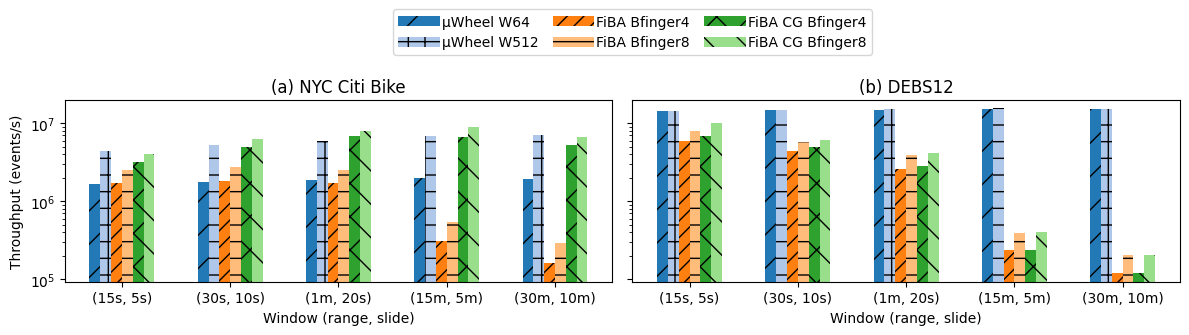

In [1004]:
plot_throughput_many(nyc_citi_small_json, debs12_small_range, 'nyc_citi_debs12_throughput_1_3', legend=True)

### Workload Distribution

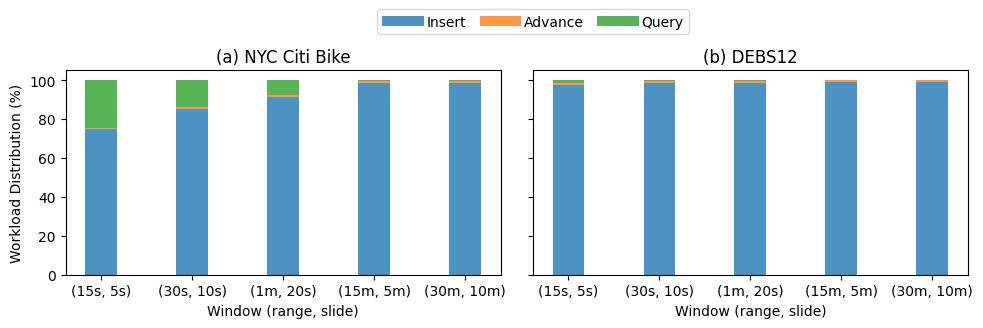

In [1005]:
plot_workload_distribution_many(nyc_citi_small_json, debs12_small_range, 'nyc_debs12_small_range_distribution')

### Aggregate Operations

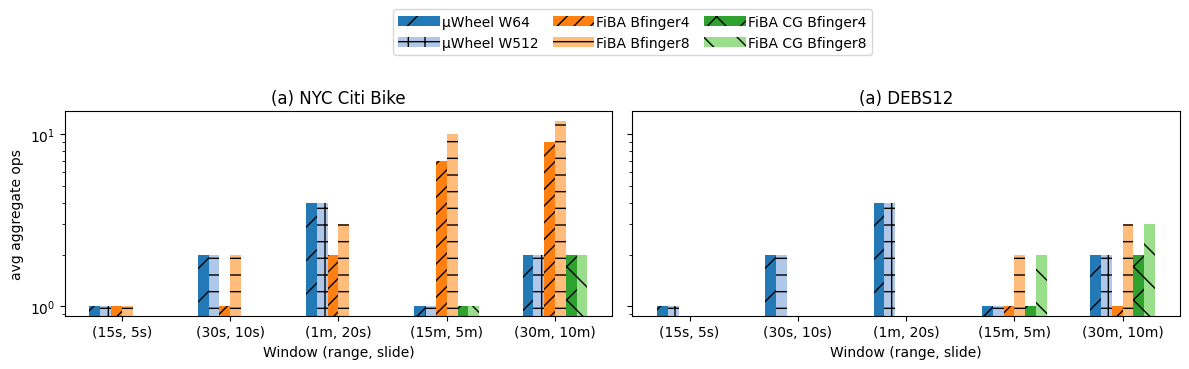

In [1006]:
plot_avg_combines_many(nyc_citi_small_json, debs12_small_range, 'nyc_debs12_avg_combines_1_3')

### Insert Latency

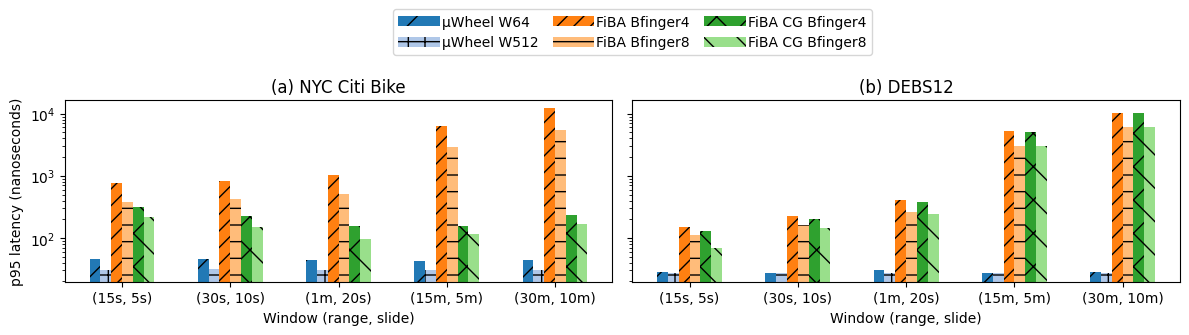

In [1007]:
plot_latency_many(nyc_citi_small_json, debs12_small_range, 'insert_latency', True, 'nyc_debs12_small_range_insert_latency')

### Query Latency

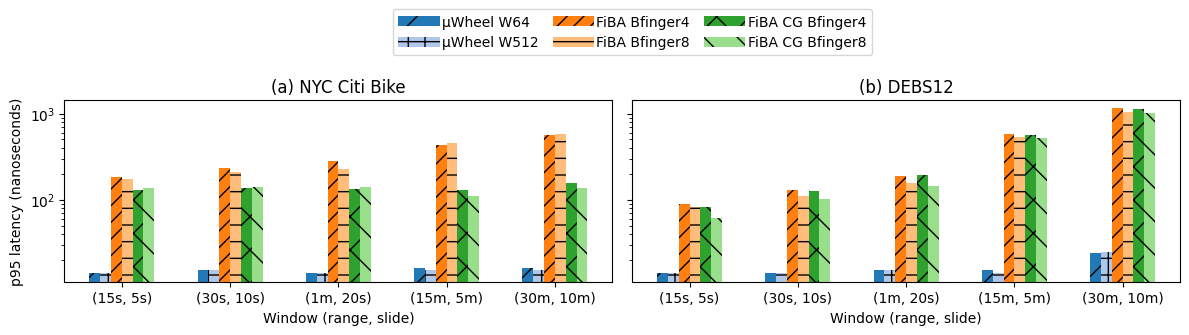

In [1008]:
plot_latency_many(nyc_citi_small_json, debs12_small_range, 'query_latency', True, 'nyc_debs12_small_range_query_latency')

### Advance Latency

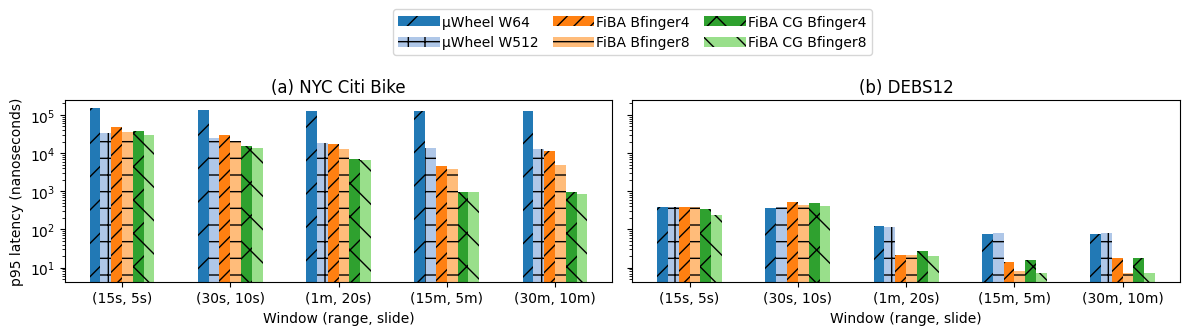

In [1009]:
plot_latency_many(nyc_citi_small_json, debs12_small_range, 'advance_latency', True, 'nyc_debs12_small_range_advance_latency')

## Big 

### Throughput

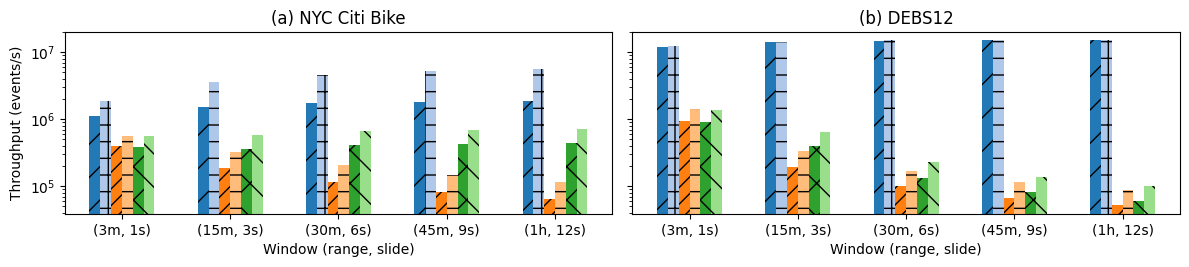

In [1010]:
plot_throughput_many(nyc_citi_big_json, debs12_big_range, 'nyc_citi_debs12_throughput_1_300', legend=False)

### AVG Combines

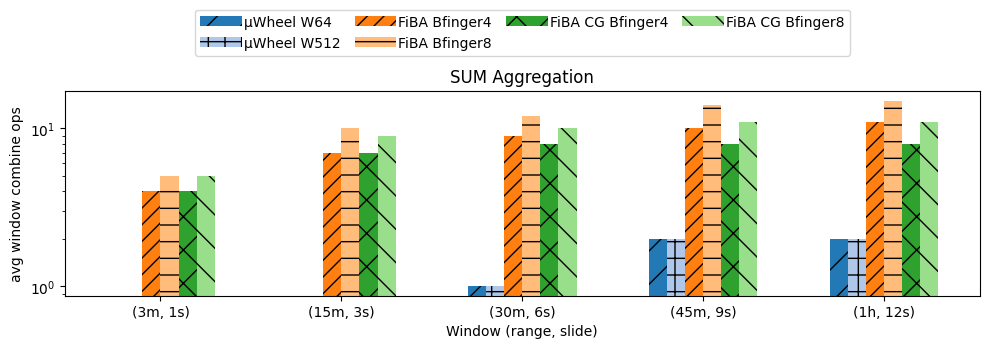

In [1011]:
plot_avg_combines(nyc_citi_big_json, True)

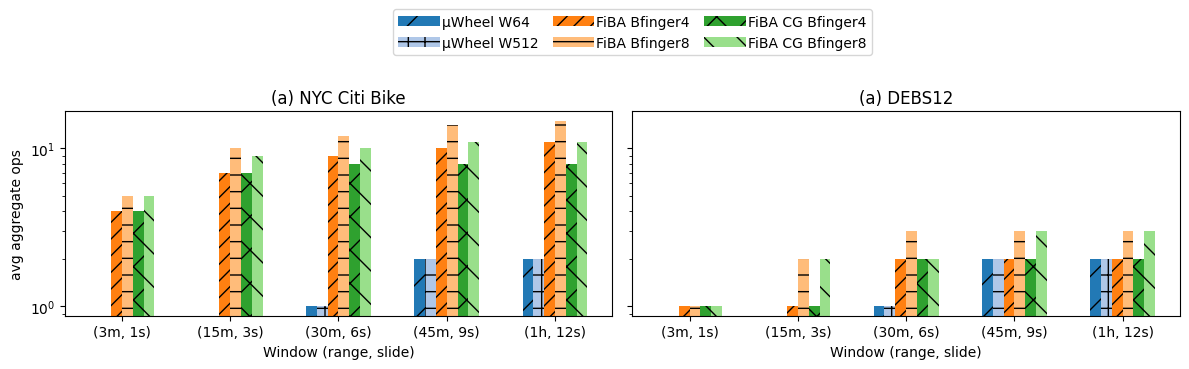

In [1012]:
plot_avg_combines_many(nyc_citi_big_json, debs12_big_range, 'nyc_debs12_avg_combines_1_300')

### Workload Distribution

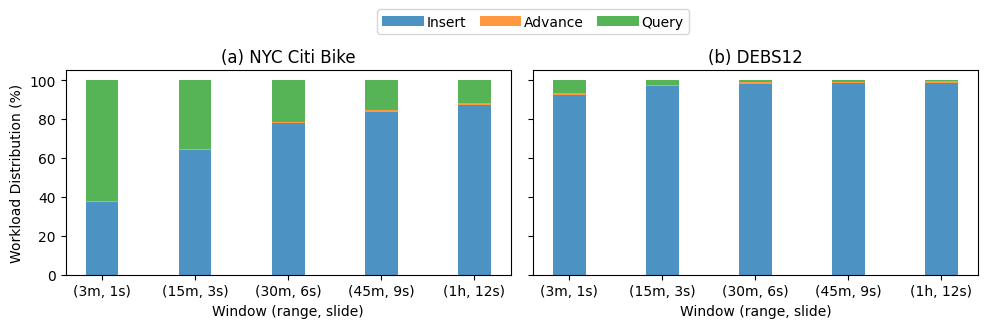

In [1013]:
plot_workload_distribution_many(nyc_citi_big_json, debs12_big_range, 'nyc_debs12_big_range_work_distribution')

### Insert latency

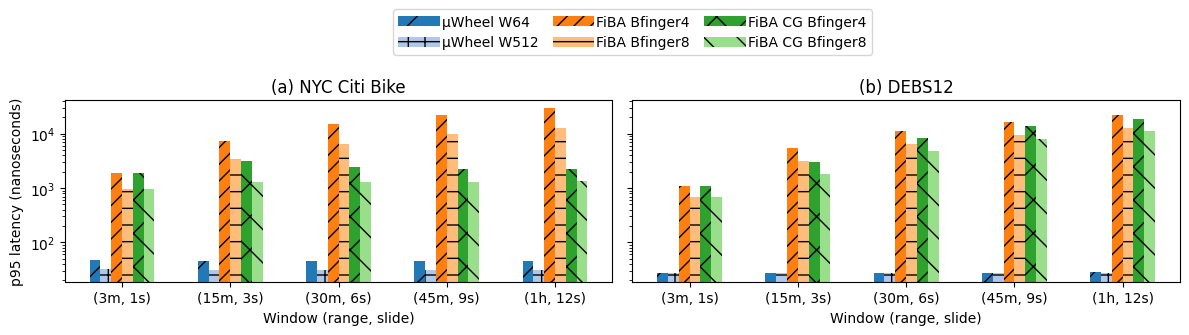

In [1014]:
plot_latency_many(nyc_citi_big_json, debs12_big_range, 'insert_latency', True, 'nyc_debs12_insert_latency_1_300')

### Query Latency

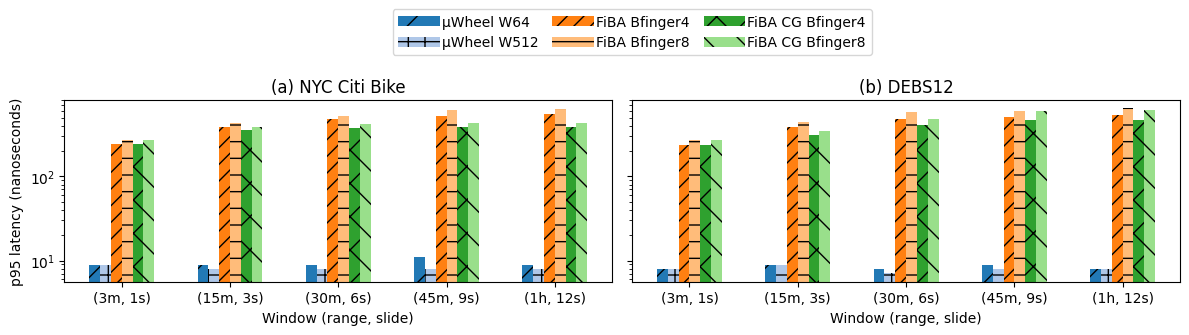

In [1015]:
plot_latency_many(nyc_citi_big_json, debs12_big_range, 'query_latency', True, 'nyc_debs12_big_range_query_latency')

### Advance Latency

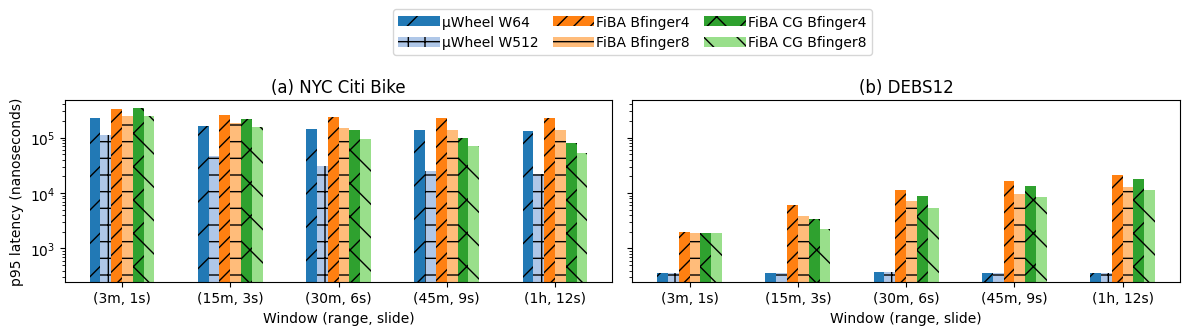

In [1016]:
plot_latency_many(nyc_citi_big_json, debs12_big_range, 'advance_latency', True, 'nyc_debs12_big_range_advance_latency')

### Analysis

In contrast to the DEBS12 dataset, NYC Citi Bike does not have as high insert rate per second and this leads to more even distribution between inserts and queries. However, as seen in the figure, the insert % grows when the number of concurrent windows decrease.

Summary: The workload that dominates the execution is inserts

# Takeaways

1. For both datasets (NYC Citi Bike and DEBS12) inserts dominate the execution.
2. FiBA is not explicitly designed for time-based windows and does not roll-up and compact temporal aggregates over time leading to worse performance when window range grows
3. The performance difference between raw FiBA and Pairs + FiBA is very small. The former uses one tree and has better overall performance whereas the latter has better query latency.
4. Wheels acheive a stable avg latency for inserts by decoupling writes/reads and peforming lazy index maintenance when the low watermark advances
5. If the aggregate function is invertible then eager wheels supports both great insert and query performance over varying window specs


## Analytical

In [1024]:
file_path = 'results/analytical_bench_1_eps.json' 
analytical_json = read_json_data(file_path)
file_path = 'results/analytical_bench_1_eps_20000.json' 
analytical_20000_json = read_json_data(file_path)
file_path = 'results/analytical_bench_1_eps_15000.json' 
analytical_15000_json = read_json_data(file_path)

File not found: results/analytical_bench_1_eps.json


### Latency

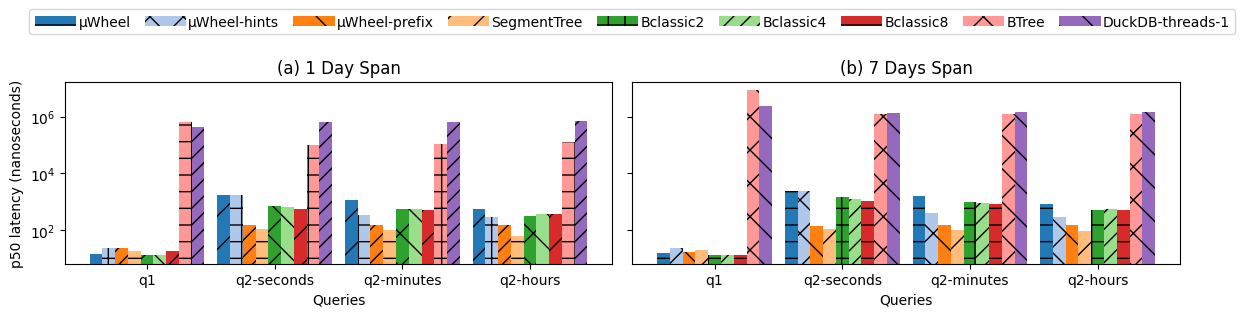

In [1018]:
plot_analytical_latency(analytical_15000_json, 'analytical_latency')

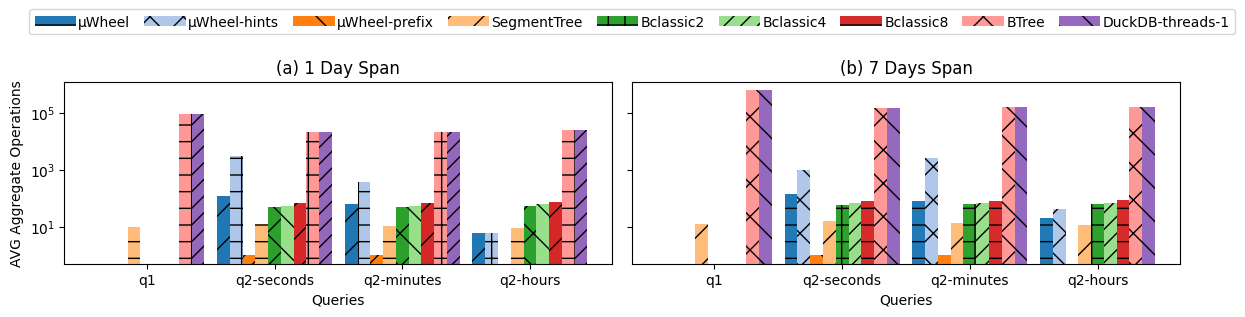

In [1019]:
plot_analytical_avg_combines(analytical_15000_json, 'analytical_avg_combines')

### Memory Usage

In [1025]:
print_memory_usage(analytical_15000_json)

Run 1:
Memory Usage:
μWheel Memory: 0.6710281372070312
μWheel-prefix Memory: 1.3413848876953125
Segment Tree Memory: 0.6591796875
BTree Memory: 1.3183822631835938
DuckDB Memory: 8.4MB
Bclassic2 Memory: 7.91015625
Bclassic4 Memory: 13.18359375
Bclassic8 Memory: 23.73046875
-----------
Run 2:
Memory Usage:
μWheel Memory: 4.6933441162109375
μWheel-prefix Memory: 9.385841369628906
Segment Tree Memory: 4.6142578125
BTree Memory: 9.228538513183594
DuckDB Memory: 51.6MB
Bclassic2 Memory: 55.37109375
Bclassic4 Memory: 92.28515625
Bclassic8 Memory: 166.11328125
-----------


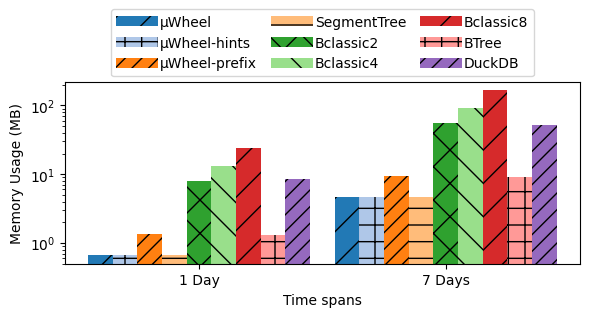

In [1026]:
plot_memory(analytical_15000_json, 'analytical_memory')